<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

Можно делать onehot encoding для букв, затем делать свертки на последовательности фиксированной длины (это и будет решение для неогр. длины входа). Проблема в том, что мы не учитываем последовательность букв. Можно использовать n-граммы, но это сильно увеличивает и без того немаленький датасет + по большому счету это эвристика/костыль.

**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

Ключевая особенность LSTM в том, что она может дольше сохранять информацию о прошлом, как следствие, лучше выучивает грамматику. Из минусов -- градиенты могут 'взорваться'.

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?

$\frac{d c_{n+1}}{d c_{k}} = \frac{d c_{n+1}}{d c_{n}}\frac{d c_{n}}{d c_{k}}$


**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?

У BPTT затухает градиент. TBPTT борется с этой проблемой: запуская BPTT определенное количество интераций каждое фиксированное количество шагов.


**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

По картинкам генерировать описание, звуки. Можно делать image captioning для видео и делать style transfer, генерировать новые названия получившимся объектам и т.п.

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

<Ответ>

лучшее качество кросс-энтропии: $2.04704605341$

Получившиеся прогнозы:
- a small dog laying in a grassy field
- a small cat is sitting on the green grass
- a very cute small furry animal in the grass

* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline. It can help u https://ars-ashuha.ru/slides/2016.11.11_ImageCaptioning/image_captionong.pdf 

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [1]:
# !wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
# !tar -xvzf data.tar.gz

### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 2.68 s, sys: 600 ms, total: 3.28 s
Wall time: 3.2 s


In [3]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [5]:
from collections import defaultdict

In [6]:
# Build a Vocabulary

word_counts = defaultdict(int)
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        for word in captions[img_i][caption_i]:
            word_counts[word] += 1

In [7]:
word_counts['#END#']

616767

In [8]:
vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [9]:
n_tokens

10373

In [10]:
word_to_index['#END#']

8134

In [11]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [12]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,  3980,  6254,  8134,    -1,    -1],
       [ 8481,  6766,  1243,  8902,  1021,  9095,  6254,  3980,  8256,
          727,  5915,  8134,    -1,    -1,    -1],
       [ 8481,  8717,  4136, 10058,  9934,  5915,  4859,  6766,  5627,
         8639,   535,  5470,  7115,  5155,  8134],
       [ 8481,  8717,  8897,  3069,  2538,   781,  8717,  8897,  1558,
         8134,    -1,    -1,    -1,    -1,    -1],
       [ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,   535,  5470,  8919,  8134,    -1]], dtype=int32)

### Mah Neural Network

In [13]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 1024 #pls change me if u want
LSTM_UNITS = 1024 #pls change me if u want

In [14]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

/home/igor/anaconda2/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6020 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:04.0)


In [15]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [16]:
#network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

#embeddings for words 
l_word_embeddings = EmbeddingLayer(l_words, len(vocab), EMBED_SIZE)

In [17]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
# l_image_features_small = <Apply Dropout Layer to regularise your Net>
l_image_features_small = DropoutLayer(l_image_features, p=0.5)
# l_image_features_small = <Apply Dense to acive LSTM_UNITS size of representation>
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)
assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [18]:
grad_clip = 300

In [19]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=grad_clip)

In [20]:
# !pip install --upgrade https://github.com/yandexdataschool/AgentNet/archive/master.zip

In [21]:
# Decoding of rnn hiden states
# http://agentnet.readthedocs.io/en/master/user/install.html
# !./install_agentnet.sh
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 1024)
output shape =  (None, None, 10373)


In [22]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
# loss = <mean over non-PAD tokens>
# loss = loss[output_mask].mean()
loss = (loss * output_mask).sum() / output_mask.sum()

In [23]:
sh_lr = theano.shared(lasagne.utils.floatX(0.1))

In [24]:
#trainable NN weights
weights = lasagne.layers.get_all_params(predicted_probabilities, trainable=True)
updates = lasagne.updates.momentum(loss,
                                   weights,
                                   learning_rate=sh_lr,
                                   momentum=0.9)

In [25]:
print(weights)

[W, W, b, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W, b]


In [26]:
%%time
# compile a function that takes input sentence and image mask, outputs loss and updates weights
# please note that your functions must accept image features as FIRST param and sentences as second one

train_step = theano.function([image_vectors, sentences],
                             loss,
                             updates=updates,
                             allow_input_downcast=True)

/home/igor/anaconda2/lib/python2.7/site-packages/theano/tensor/basic.py:5130: UserWarning: flatten outdim parameter is deprecated, use ndim instead.
  "flatten outdim parameter is deprecated, use ndim instead.")


CPU times: user 8.35 s, sys: 232 ms, total: 8.58 s
Wall time: 8.91 s


In [27]:
%%time
val_step = theano.function([image_vectors, sentences],
                             loss,
                             allow_input_downcast=True)

CPU times: user 1.12 s, sys: 32 ms, total: 1.15 s
Wall time: 1.12 s


# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [28]:
captions = np.array(captions)

In [29]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [30]:
generate_batch(img_codes, captions, 2)

(array([[ 1.12288892,  0.38240808,  4.73529577, ..., -1.1541096 ,
          2.60740471, -0.77975619],
        [-1.93355632, -0.43573451, -0.45779261, ..., -0.15569481,
         -1.22766078, -1.56038845]], dtype=float32),
 array([[8481, 8717, 8946, 4859, 2665, 3069,  781, 7130, 4859, 8717, 5822,
         8134],
        [8481, 8717, 2978, 3935, 3980, 8717, 5287, 2748,  781, 8717, 4556,
         8134]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [31]:
batch_size = 100 #adjust me
n_epochs   = 1000 #adjust me
n_batches_per_epoch = 100 #adjust me
n_validation_batches = 10 #how many batches are used for validation after each epoch

In [32]:
# !pip install tqdm

In [33]:
from IPython import display
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
sh_lr = theano.shared(lasagne.utils.floatX(0.1))
train_loss_history = []
test_loss_history = []

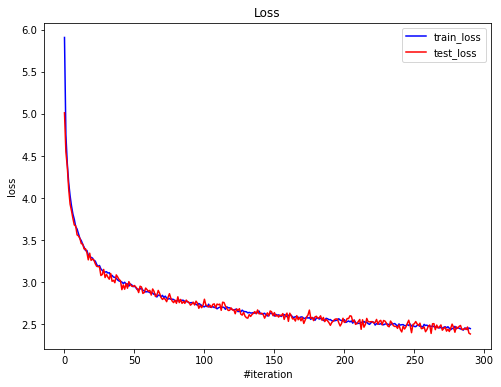

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 290, train loss: 2.44604798794, val loss: 2.38203113079
('LR: ', array(0.000391353911254555, dtype=float32))


 24%|██▍       | 24/100 [00:07<00:24,  3.11it/s]


KeyboardInterrupt: 

In [35]:
for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes, captions, batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    
    train_loss_history.append(train_loss)
    test_loss_history.append(val_loss)
    plt.title("Loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(train_loss_history, 'b', label='train_loss')
    plt.plot(test_loss_history, 'r', label='test_loss')
    plt.legend(loc='best')
    plt.show()
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
    print('LR: ', sh_lr.get_value())
    
    try:
        if (epoch + 1) % 50 == 0 or (train_loss_history[-1] - train_loss_history[-2]) > 0.2:
            if sh_lr.get_value < 0.0001:
                if (epoch + 1) % 100 == 0:
                    new_lr = theano.shared(lasagne.utils.floatX(sh_lr.get_value() * 0.66))
            else:
                new_lr = theano.shared(lasagne.utils.floatX(sh_lr.get_value() * 0.33))
            print('\n Decressing LR: {} -> {}'.format(sh_lr.get_value(), new_lr.get_value()))
            if new_lr.get_value() > 10**(-6):
                sh_lr = new_lr
    except Exception as e:
        print("err at changing lr: {}".format(e))
    
print("Finish :)")

In [44]:
# добавим LR
sh_lr = theano.shared(0.002)
n_epochs = 500

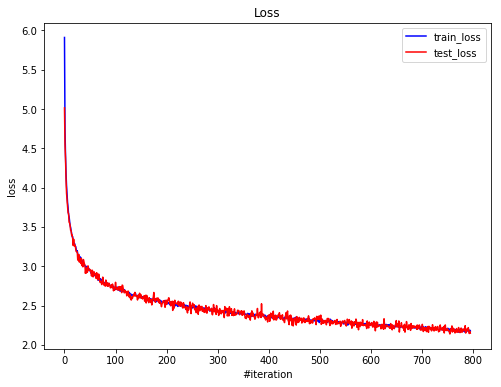


Epoch: 499, train loss: 2.1767558229, val loss: 2.14894298315
('LR: ', array(0.00021779999951831996, dtype=float32))

 Decressing LR: 0.000217799999518 -> 7.18739975127e-05
Finish :)


In [47]:
for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes, captions, batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    
    train_loss_history.append(train_loss)
    test_loss_history.append(val_loss)
    plt.title("Loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(train_loss_history, 'b', label='train_loss')
    plt.plot(test_loss_history, 'r', label='test_loss')
    plt.legend(loc='best')
    plt.show()
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
    print('LR: ', sh_lr.get_value())
    
    try:
        if (epoch + 1) % 100 == 0 or (train_loss_history[-1] - train_loss_history[-2]) > 0.1:
            new_lr = theano.shared(lasagne.utils.floatX(sh_lr.get_value() * 0.33))
            print('\n Decressing LR: {} -> {}'.format(sh_lr.get_value(), new_lr.get_value()))
            if new_lr.get_value() > 10**(-4):
                sh_lr = new_lr
    except Exception as e:
        print("err at changing lr: {}".format(e))
    
print("Finish :)")

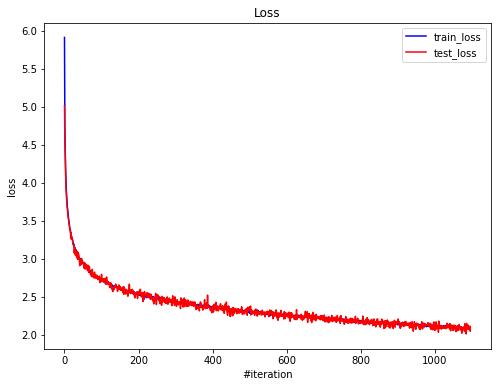


Epoch: 299, train loss: 2.08686791539, val loss: 2.04704605341
('LR: ', array(0.00021779999951831996, dtype=float32))

 Decressing LR: 0.000217799999518 -> 7.18739975127e-05
Finish :)


In [48]:
for epoch in range(300):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes, captions, batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    
    train_loss_history.append(train_loss)
    test_loss_history.append(val_loss)
    plt.title("Loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(train_loss_history, 'b', label='train_loss')
    plt.plot(test_loss_history, 'r', label='test_loss')
    plt.legend(loc='best')
    plt.show()
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
    print('LR: ', sh_lr.get_value())
    
    try:
        if (epoch + 1) % 100 == 0 or (train_loss_history[-1] - train_loss_history[-2]) > 0.1:
            new_lr = theano.shared(lasagne.utils.floatX(sh_lr.get_value() * 0.33))
            print('\n Decressing LR: {} -> {}'.format(sh_lr.get_value(), new_lr.get_value()))
            if new_lr.get_value() > 10**(-4):
                sh_lr = new_lr
    except Exception as e:
        print("err at changing lr: {}".format(e))
    
print("Finish :)")

### apply trained model

In [49]:
#the same kind you did last week, but a bit smaller
# pip install scikit-image
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [50]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

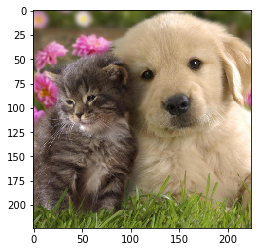

In [51]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [52]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=2,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [71]:
for i in range(10):
    print ' '.join(generate_caption(img,t=2., sample=False)[1:-1])

a small dog laying in a grassy field
a small furry animal in a grassy field
a small furry animal eating out of a green plant
a small kitten is looking at a white bird
a small furry animal in a flower pot
a small cat is sitting on the green grass
a white cat with a piece of broccoli in its mouth
a white cat laying on the ground with a toy
a small dog is laying down with a toy
a small dog is laying down on the grass


In [74]:
for i in range(50):
    print ' '.join(generate_caption(img,t=2., sample=True)[1:-1])

a small furry animal standing in the grass
a little boy in a red jacket holding a white frisbee
a cat laying down next to a teddy bear
a little kitten is in a grassy area
a white cat with a red and white fur and a cat in its mouth
a cat is laying on a white blanket
a very cute small furry animal in the grass
a cat that is laying down on the ground
a cat is eating a piece of broccoli
two birds that are sitting on the ground
a very cute furry animal eating something on the ground
a small furry animal in a field with a plate
a small cat is eating a dead bird
a little cat that is laying on a car
a white fluffy cat laying on the ground with a toy in its mouth
a cat that is laying down on the grass
a cat that is eating some food on the ground
a little furry animal eating food out of a container
a close up of a cat on a car
a very cute small dog in a car
a cat laying in a box with a piece of broccoli
a cat sitting on a wooden floor with a basket on its back
a couple of cats are standing on th

# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 